### Shaded plot

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import math

from scipy.linalg import expm, hadamard, signm
import numpy as np

import os

import seaborn as sns

import logging
import math

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '/home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/src/neuralnet')
# sys.path.insert(0, '/home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/src/')
import datagenerator
from models import MatrixNet
from common import get_logger

2024-09-01 00:31:51,879 - datagenerator - INFO - Using device: cuda


In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
save_dir = "/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030"

In [5]:
logger = get_logger()

In [6]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

2024-09-01 00:31:51,891 - root - INFO - Using device: cuda


In [7]:
test_samples = 2**15  # 16384
k_values = range(5, 19)
train_samples = [(2**k) + test_samples for k in k_values]
dim = 2

In [8]:
logger.info(f"{train_samples=}, {test_samples=}")

relative_errors = []

2024-09-01 00:31:51,902 - root - INFO - train_samples=[32800, 32832, 32896, 33024, 33280, 33792, 34816, 36864, 40960, 49152, 65536, 98304, 163840, 294912], test_samples=32768


In [9]:
train_vals = [2**k for k in range(5, 19)]
models_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", f'exp_model_{str(x)}.pth'), train_vals)]
train_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "train", f'train_dataset_{str(x)}.pt'), train_vals)]
test_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "test", f'test_dataset_{str(x)}.pt'), train_vals)]

logger.info(f"{models_lst=}\n\n{train_lst=}\n\n{test_lst=}")

2024-09-01 00:31:51,906 - root - INFO - models_lst=['/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_32.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_64.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_128.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_256.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_512.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_1024.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_2048.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_4096.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_8192.pth', '/mnt/wd_2tb/thesis_transformers/experiments/exponential/2024090

In [10]:
test_lst[0]

'/mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/test/test_dataset_32.pt'

In [11]:
# Load the saved model
model = MatrixNet(dim*dim).to(device)
model.load_state_dict(torch.load(models_lst[0]))
logger.info(model)

<All keys matched successfully>

In [12]:
mu_lst = []
sigma_lst = []
y_main_lst = []
u_shaded_lst = []
l_shaded_lst = []
for idx, train_val in enumerate(train_vals):

    # Load the saved model
    model = MatrixNet(dim*dim).to(device)
    model.load_state_dict(torch.load(models_lst[idx]))
    model.eval()

    # Loading the test dataset
    test_dataset = torch.load(test_lst[idx])

    logger.info(f"{idx=}\nLoaded model: {models_lst[idx]}")
    logger.info(f"{len(test_dataset)=}")

    actuals = []
    predicted = []

    logger.info(f"Starting to predict values in the test_dataset")
    with torch.no_grad():
        logger.info(f"{dim=}")
        for x, y in test_dataset:
            if dim == 1:
                predicted.append(model(x.view(-1, 1).to(device).to(torch.float64)))
                actuals.append(y.view(-1,1).to(device).to(torch.float64))
            else:
                predicted.append(model(x.view(1, dim*dim).to(device).to(torch.float64)))
                actuals.append(y.view(1, dim*dim).to(device).to(torch.float64))
                    
    
        predicted = torch.cat(predicted, 0)
        actuals = torch.cat(actuals, 0)
        
        logger.info(f"\n{predicted.shape=}\n{actuals.shape=}")
        
        np_predicted = predicted.view(-1).cpu().numpy()
        np_actuals = actuals.view(-1).cpu().numpy()

        logger.info(f"{np_predicted.dtype=},{np_actuals.dtype=}")
        
        # mu = np.mean(np.log10(np_predicted))
        mu = np.mean(np.log10(np.abs(np_predicted - np_actuals)))
        sigma = (np_predicted.shape[0] -1)**-1 * np.sum((np.log10(np.abs(np_predicted - np_actuals)) - mu)**2)
        
        y_main = 10**mu 
        
        u_shaded = 10**(mu - sigma)
        l_shaded = 10**(mu + sigma)
        
        logger.info(f"{mu=},{sigma=}")
        logger.info(f"{y_main=},{u_shaded=},{l_shaded=}")
        
        x_raw = np.repeat(train_vals[idx], np_predicted.shape[0])
        y_raw = np_actuals
        
        logger.info(f"{x_raw.shape=}, {y_raw.shape=}")

        mu_lst.append(mu)
        sigma_lst.append(sigma)
        y_main_lst.append(y_main)
        u_shaded_lst.append(u_shaded)
        l_shaded_lst.append(l_shaded)

2024-09-01 00:31:52,032 - root - INFO - MatrixNet(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)
2024-09-01 00:31:52,035 - root - INFO - idx=0
Loaded model: /mnt/wd_2tb/thesis_transformers/experiments/exponential/20240901000030/dim_2/exp_model_32.pth
2024-09-01 00:31:52,035 - root - INFO - len(test_dataset)=32768
2024-09-01 00:31:52,035 - root - INFO - Starting to predict values in the test_dataset
2024-09-01 00:31:52,035 - root - INFO - dim=2
2024-09-01 00:31:56,959 - root - INFO - 
predicted.shape=torch.Size([32768, 4])
actuals.shape=torch.Size([32768, 4])
2024-09-01 00:31:56,960 - root - INFO - np_predicted.dtype=dtype('float64'),np_actuals.dtype=dtype('float64')
2024-09-01 00:31:56,962 - root - INFO - mu=-1.3829774397679946,sigma=0.3346227113989956
2024-09-01 00:31:56,

In [13]:
mu_lst

[-1.3829774397679946,
 -1.5518760065494688,
 -1.7544617429911047,
 -1.9403890619615347,
 -2.0427582492977425,
 -2.2073260540811575,
 -2.3412575469044867,
 -2.122134583940082,
 -2.3167765198894816,
 -2.3995862437740083,
 -2.4987926396290354,
 -2.5649499542798035,
 -2.7804115201066475,
 -2.695521068235474]

### Rough Sketch

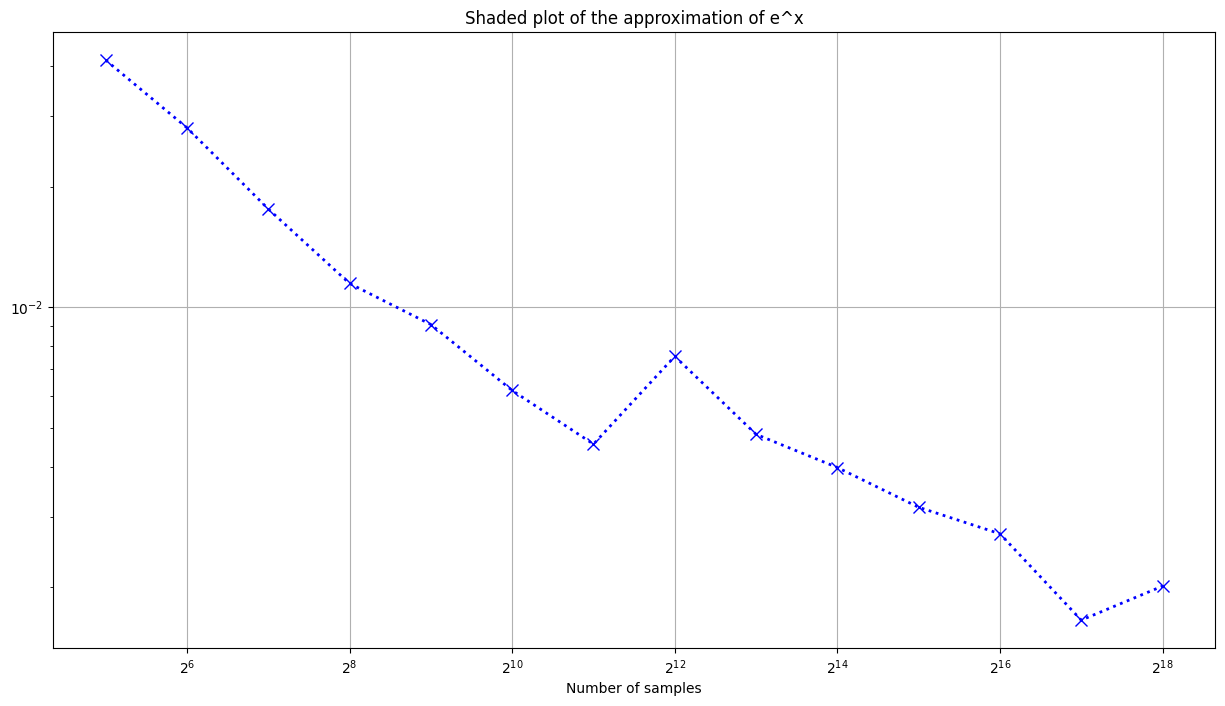

In [14]:
plt.figure(figsize=(15, 8))

plt.grid()
# plt.plot(x_raw, y_raw)
plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8)
plt.xlabel("Number of samples")


plt.xticks([2**k for k in k_values])
plt.yticks([10**k for k in k_values])
plt.xscale('log', base=2)
plt.yscale('log', base=10)


plt.title("Shaded plot of the approximation of e^x")
plt.show()

## Shaded Plot

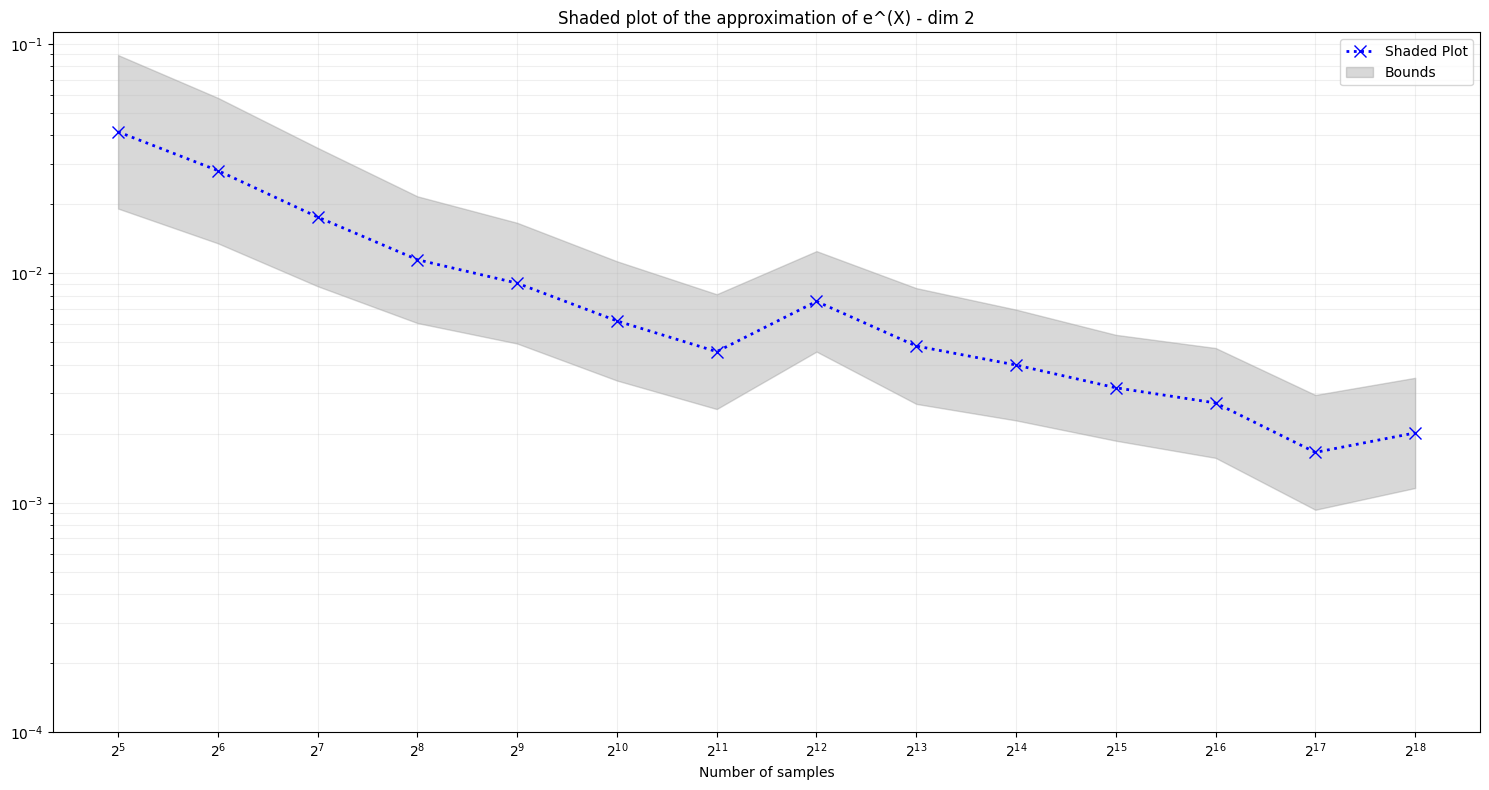

In [25]:
# Your existing data
# train_vals = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
# mu_lst = [0.0025189347, -0.0030112644, 0.0018056722, 0.00024630464, -0.0018855985, 0.00081260776, -0.0035950374, -0.0015076925, 0.00010364427, -0.0008442651, 0.00014675909, 0.0005134512, 0.0008943669, 0.00058361713]

# # Upper and lower bounds
# upper_bounds = [0.87437994331586, 0.8589856091986053, 0.8720893378924958, 0.8655245974598067, 0.8616714614469541, 0.866559207650375, 0.8581177330481463, 0.8626829584139304, 0.8656539427892145, 0.8637384055476058, 0.865978438284143, 0.8664403425328335, 0.8658090298992606, 0.8661159388212001]
# lower_bounds = [1.157011517572361, 1.1481313700565632, 1.1562463306422472, 1.156679915576484, 1.1505012466549305, 1.1583157837635798, 1.1462069789816558, 1.151153918054339, 1.1557475383338336, 1.1532653376919344, 1.1555438736045827, 1.1568797971867635, 1.1597559860949047, 1.1576871250884513]

k_values = range(5, 19)

plt.figure(figsize=(15, 8))
plt.grid(True, which="both", ls="-", alpha=0.2)


# Plot the main curve
plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8, label='Shaded Plot')

u_shaded_lst = [0 if math.isnan(x) else x for x in u_shaded_lst]
l_shaded_lst = [0 if math.isnan(x) else x for x in l_shaded_lst]
# Add the shaded region
plt.fill_between(train_vals, u_shaded_lst, l_shaded_lst, alpha=0.3, color='grey', label='Bounds')

plt.xlabel("Number of samples")
# plt.ylabel("Relative Error")
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.title(f"Shaded plot of the approximation of e^(X) - dim {dim}")

# Set x-ticks
# plt.xticks([2**k for k in k_values], [f'2^{k}' for k in k_values], rotation=45)
plt.xticks([2**k for k in k_values])
plt.yticks([10**k for k in range(-1, -5, -1)])

# Set y-ticks
# y_ticks = [0.8, 0.9, 1.0, 1.1, 1.2]
# plt.yticks(y_ticks, [f'{y:.1f}' for y in y_ticks])

# y_ticks = np.arange(10**0, 10**-4)
# plt.yticks(y_ticks)

# Add legend
plt.legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig(os.path.join(save_dir, f"shaded_plot_dim_{dim}.png"))
# Show the plot


plt.show()

In [18]:
y_ticks

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])